In [1]:

# Import required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define the correct file path
file_path = r"C:\Users\srahman\OneDrive - The Spectator 1828 Ltd\Desktop\for Samya\2024\Adam 2024\anaconda\marketing_scientist_take_home_task_dataset.xlsx"

# Load the Excel file
df = pd.read_excel(file_path)

# Display the first few rows
print(df.head())


        WEEK COUNTRY  Customer Conversions  SEO Visitors  Affiliates Visitors  \
0 2018-12-31  Mexico                  9091         71269                 3253   
1 2019-01-07  Mexico                 11560         85551                 4301   
2 2019-01-14  Mexico                 11981         97112                 4777   
3 2019-01-21  Mexico                 11244         79018                 5066   
4 2019-01-28  Mexico                 14113         79993                 6354   

   Facebook Media Spend  Facebook Impressions Facebook Currency  \
0                   NaN                   NaN               NaN   
1                   NaN                   NaN               NaN   
2                   NaN                   NaN               NaN   
3                   NaN                   NaN               NaN   
4                   NaN                   NaN               NaN   

   Display Media Spend  Display Impressions  ...  Tik Tok Impressions  \
0                 4165               

In [2]:
##EDA

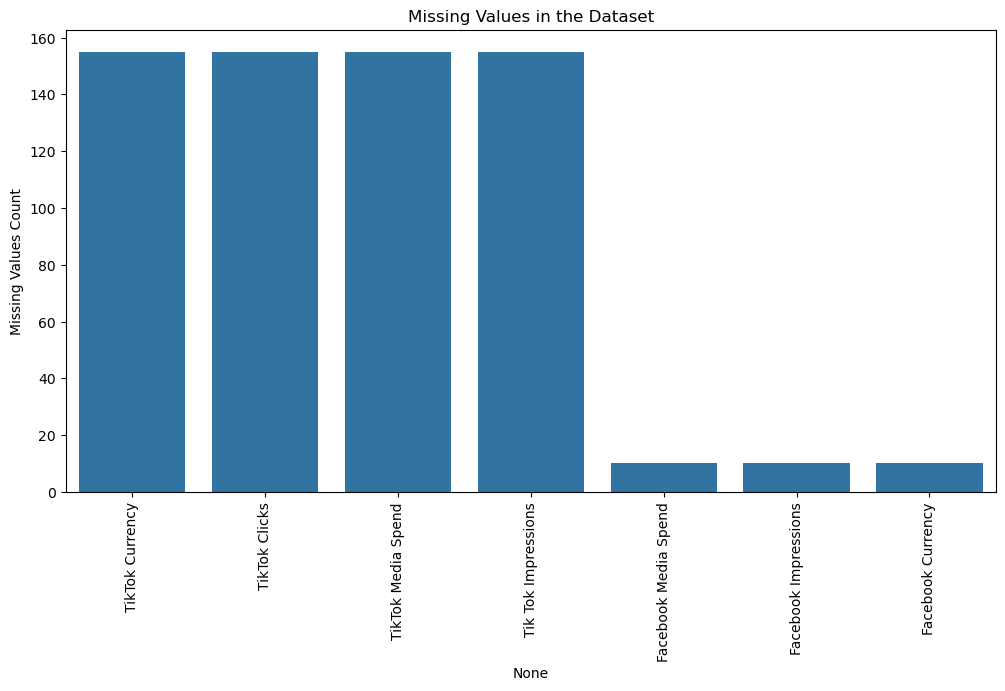

In [3]:
# Summary statistics
summary_stats = df.describe()

# Missing values analysis
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_values = missing_values[missing_values > 0]

# Plot missing values
plt.figure(figsize=(12, 6))
sns.barplot(x=missing_values.index, y=missing_values.values)
plt.xticks(rotation=90)
plt.ylabel("Missing Values Count")
plt.title("Missing Values in the Dataset")
plt.show()

# Displaying the summary statistics
##import ace_tools as tools
##tools.display_dataframe_to_user(name="Summary Statistics", dataframe=summary_stats)

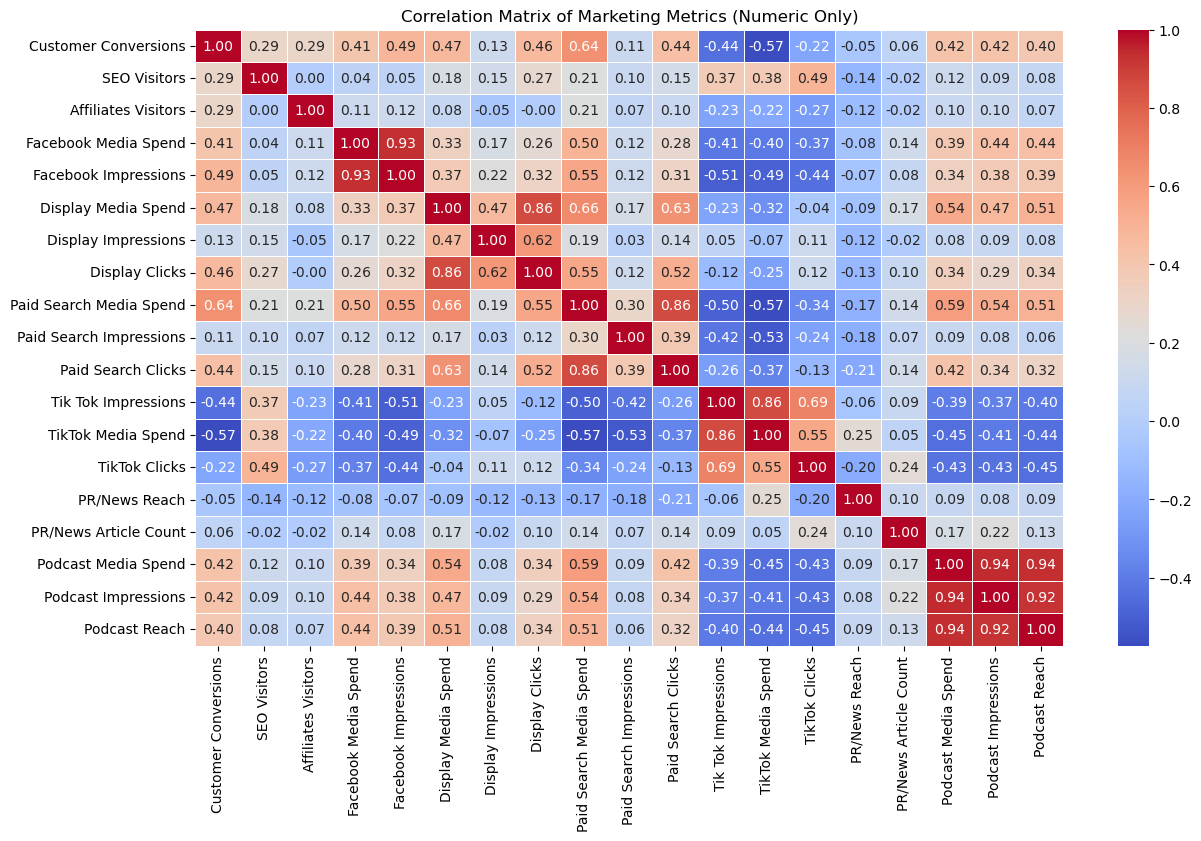

In [9]:
# Selecting only numeric columns for correlation matrix
numeric_df = df.select_dtypes(include=['number'])

# Plot the corrected correlation matrix
plt.figure(figsize=(14, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Marketing Metrics (Numeric Only)")
plt.show()


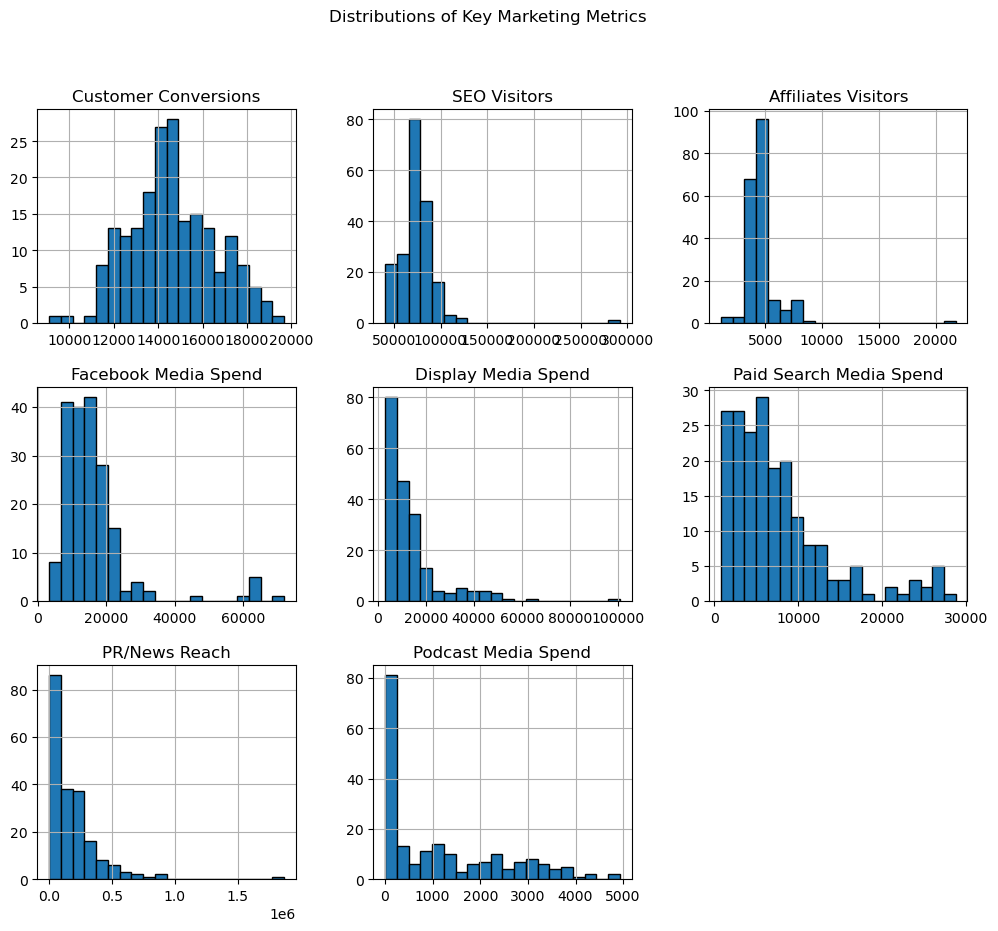

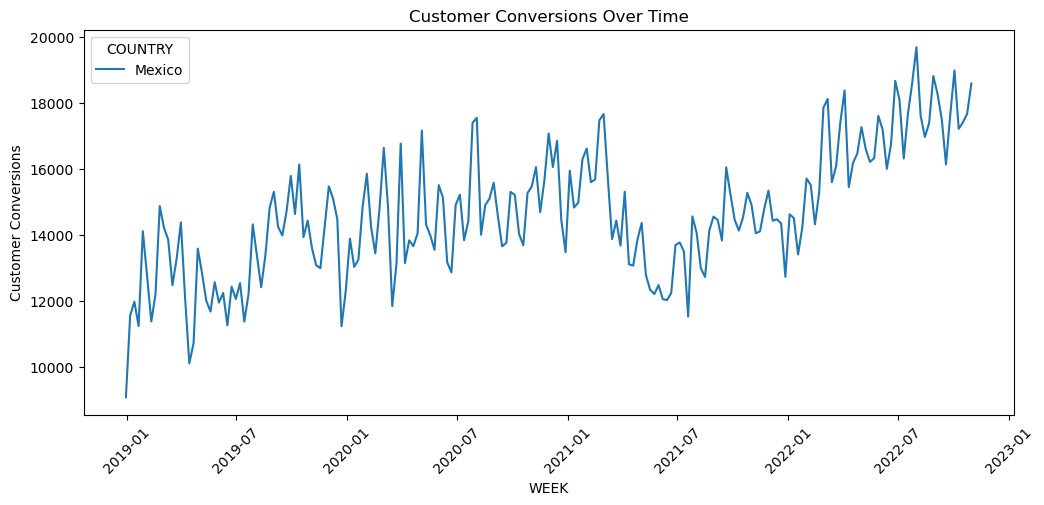

In [7]:

# Plot distributions of key metrics
key_metrics = ["Customer Conversions", "SEO Visitors", "Affiliates Visitors", 
               "Facebook Media Spend", "Display Media Spend", "Paid Search Media Spend",
               "PR/News Reach", "Podcast Media Spend"]

df[key_metrics].hist(figsize=(12, 10), bins=20, layout=(3, 3), edgecolor='black')
plt.suptitle("Distributions of Key Marketing Metrics")
plt.show()

# Time-series trend of Customer Conversions over time
plt.figure(figsize=(12, 5))
sns.lineplot(data=df, x="WEEK", y="Customer Conversions", hue="COUNTRY")
plt.xticks(rotation=45)
plt.title("Customer Conversions Over Time")
plt.show()


In [40]:
###Random Forest

In [72]:
# Data Cleaning and Preprocessing

# Basic dataset overview
dataset_overview = {
    "Number of Rows": df.shape[0],
    "Number of Columns": df.shape[1],
    "Columns": list(df.columns),
}

# Data Types
data_types = df.dtypes.to_dict()

# Checking for missing values
missing_values = df.isnull().sum()[df.isnull().sum() > 0].to_dict()

# Date Range
date_range = {
    "Start Date": df["WEEK"].min(),
    "End Date": df["WEEK"].max(),
}

In [74]:
# Handle Missing Data
df = df.copy()  # Avoid chained assignment issues

# Convert columns to numeric, forcing errors to NaN
df['Facebook Media Spend'] = pd.to_numeric(df['Facebook Media Spend'], errors='coerce')
df['Facebook Impressions'] = pd.to_numeric(df['Facebook Impressions'], errors='coerce')

# Now, safely fill missing values
df['Facebook Media Spend'] = df['Facebook Media Spend'].fillna(df['Facebook Media Spend'].median())
df['Facebook Impressions'] = df['Facebook Impressions'].fillna(df['Facebook Impressions'].median())

In [76]:
# Replace missing TikTok values with zero (indicating no spend)
df[['Tik Tok Impressions', 'TikTok Media Spend', 'TikTok Clicks']] = df[
    ['Tik Tok Impressions', 'TikTok Media Spend', 'TikTok Clicks']
].fillna(0)

In [78]:
# Remove currency columns as they are redundant in numerical analysis
currency_columns = [col for col in df.columns if 'Currency' in col]
df.drop(columns=currency_columns, inplace=True, errors='ignore')

In [80]:
# Extract Year, Month, and Week Number from the 'WEEK' column
df['Year'] = df['WEEK'].dt.year
df['Month'] = df['WEEK'].dt.month
df['Week_Number'] = df['WEEK'].dt.isocalendar().week

In [82]:
# Feature Selection & Correlation Analysis

# Compute correlation matrix
corr_matrix = df.corr(numeric_only=True)

# Identify highly correlated features (above 0.85 correlation threshold)
correlation_threshold = 0.85
high_corr_pairs = [(i, j) for i in corr_matrix.columns for j in corr_matrix.columns
                   if i != j and abs(corr_matrix.loc[i, j]) > correlation_threshold]

In [84]:
# Identify features to drop due to high correlation
drop_columns = set()
for i, j in high_corr_pairs:
    drop_columns.add(j)

# Drop highly correlated features
df_reduced = df.drop(columns=drop_columns, errors='ignore')

In [86]:
# Multicollinearity Check (VIF)

#X = df_reduced.drop(columns=['WEEK', 'Customer Conversions'], errors='ignore')

#vif_data = pd.DataFrame()
#vif_data["Feature"] = X.columns
#vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Select numerical columns and drop target variable 'Customer Conversions'
X = df_reduced.drop(columns=['WEEK', 'Customer Conversions'], errors='ignore')

# Convert all columns to numeric, forcing non-numeric values to NaN
X = X.apply(pd.to_numeric, errors='coerce')

# Drop any columns with NaN values (ensures VIF runs correctly)
X = X.dropna(axis=1)

# Compute VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display VIF results
print(vif_data)

                   Feature        VIF
0             SEO Visitors  13.915746
1      Affiliates Visitors   9.012547
2      Display Impressions   2.595544
3  Paid Search Impressions   1.894302
4            PR/News Reach   1.875886
5    PR/News Article Count   1.615154
6                     Year  26.055294


In [88]:
# Drop features with VIF > 10 (high multicollinearity)
high_vif_features = vif_data[vif_data["VIF"] > 10]["Feature"].tolist()
X = X.drop(columns=high_vif_features, errors='ignore')


In [90]:
# Train-Test Split

y = df_reduced['Customer Conversions']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [92]:
# Train Models

# 1 Multiple Linear Regression Model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

# 2 Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [94]:
# Evaluate Model Performance

# Evaluation for Linear Regression
mae_linear = mean_absolute_error(y_test, y_pred_linear)
mse_linear = mean_squared_error(y_test, y_pred_linear)
rmse_linear = np.sqrt(mse_linear)
r2_linear = r2_score(y_test, y_pred_linear)

# Evaluation for Random Forest
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

In [96]:
# Feature Importance (Random Forest)
feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

In [98]:
# Spend Change Impact & Recommendations

# Identify top-performing and under-performing features based on importance scores
top_performing_channels = feature_importance.head(5)
underperforming_channels = feature_importance.tail(5)


In [100]:
# Step 10: Display Results

#tools.display_dataframe_to_user(name="Cleaned Dataset", dataframe=df_reduced)
#tools.display_dataframe_to_user(name="Feature Importance (Random Forest)", dataframe=feature_importance)

# Display first few rows of the cleaned dataset
print(" Cleaned Dataset Preview:")
print(df_reduced.head())

# Display first few rows of feature importance
print("\n Feature Importance (Random Forest):")
print(feature_importance.head())




 Cleaned Dataset Preview:
        WEEK COUNTRY  Customer Conversions  SEO Visitors  Affiliates Visitors  \
0 2018-12-31  Mexico                  9091         71269                 3253   
1 2019-01-07  Mexico                 11560         85551                 4301   
2 2019-01-14  Mexico                 11981         97112                 4777   
3 2019-01-21  Mexico                 11244         79018                 5066   
4 2019-01-28  Mexico                 14113         79993                 6354   

   Display Impressions  Paid Search Impressions  PR/News Reach  \
0               938982                    34395          79500   
1              1109680                    44619         123551   
2               591280                    48033         100448   
3               769438                    49135          98550   
4               923616                    53653          59400   

   PR/News Article Count  Year  
0                     22  2018  
1                     66

In [102]:
# Final Summary Report
final_results = {
    "Dataset Overview": dataset_overview,
    "Date Range": date_range,
    "Missing Values": missing_values,
    "Dropped Features (Collinearity)": list(drop_columns),
    "Dropped Features (High VIF)": high_vif_features,
    "Linear Regression Performance": {
        "MAE": mae_linear,
        "MSE": mse_linear,
        "RMSE": rmse_linear,
        "R-squared": r2_linear,
    },
    "Random Forest Performance": {
        "MAE": mae_rf,
        "MSE": mse_rf,
        "RMSE": rmse_rf,
        "R-squared": r2_rf,
    },
    "Top Performing Marketing Channels": top_performing_channels.to_dict(orient="records"),
    "Underperforming Marketing Channels": underperforming_channels.to_dict(orient="records"),
}

final_results

{'Dataset Overview': {'Number of Rows': 200,
  'Number of Columns': 24,
  'Columns': ['WEEK',
   'COUNTRY',
   'Customer Conversions',
   'SEO Visitors',
   'Affiliates Visitors',
   'Facebook Media Spend',
   'Facebook Impressions',
   'Display Media Spend',
   'Display Impressions',
   'Display Clicks',
   'Paid Search Media Spend',
   'Paid Search Impressions',
   'Paid Search Clicks',
   'Tik Tok Impressions',
   'TikTok Media Spend',
   'TikTok Clicks',
   'PR/News Reach',
   'PR/News Article Count',
   'Podcast Media Spend',
   'Podcast Impressions',
   'Podcast Reach',
   'Year',
   'Month',
   'Week_Number']},
 'Date Range': {'Start Date': Timestamp('2018-12-31 00:00:00'),
  'End Date': Timestamp('2022-10-31 00:00:00')},
 'Missing Values': {},
 'Dropped Features (Collinearity)': ['Display Media Spend',
  'Podcast Media Spend',
  'Month',
  'Paid Search Clicks',
  'TikTok Media Spend',
  'Paid Search Media Spend',
  'TikTok Clicks',
  'Facebook Impressions',
  'Tik Tok Impressio

In [104]:
# Import Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor

# Train Gradient Boosting Model
gbr_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr_model.fit(X_train, y_train)

# Evaluate Model Performance
y_pred_gbr = gbr_model.predict(X_test)
gbr_results = {
    "MAE": mean_absolute_error(y_test, y_pred_gbr),
    "MSE": mean_squared_error(y_test, y_pred_gbr),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_gbr)),
    "R-squared": r2_score(y_test, y_pred_gbr),
}

# Feature Importance Analysis
feature_importance_gbr = pd.DataFrame({
    "Feature": X.columns,
    "Importance": gbr_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Display feature importance
print(feature_importance_gbr)

print("Gradient Boosting Model Performance:")
for key, value in gbr_results.items():
    print(f"{key}: {value:.4f}")



                   Feature  Importance
2  Paid Search Impressions    0.593846
0      Affiliates Visitors    0.129301
1      Display Impressions    0.096995
3            PR/News Reach    0.094485
4    PR/News Article Count    0.085372
Gradient Boosting Model Performance:
MAE: 1616.7538
MSE: 4320896.7741
RMSE: 2078.6767
R-squared: 0.0341
